## Sentiment Analysis

### EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # import seaborn library for plotting 
import re
%matplotlib inline
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
# import pyLDAvis.sklearn # a specialized package for topic model visualization
from sklearn.manifold import TSNE
# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nechamaborisute/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nechamaborisute/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nechamaborisute/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# data_pr = pd.read_csv('data.csv.zip', encoding='latin-1')
# data_pr.columns = ['sentiment', 'tweet_id', 'date', 'query', 'user', 'text']

In [7]:
# Load in data already separated into train and test data
data = pd.read_csv('data.csv.zip', encoding='latin-1')

# Look at data information, dtypes, nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   polarity of tweet   1048572 non-null  int64 
 1   id of the tweet     1048572 non-null  int64 
 2   date of the tweet   1048572 non-null  object
 3   query               1048572 non-null  object
 4   user                1048572 non-null  object
 5   text of the tweet   1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


Data file format has 6 fields:
* 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* 1 - the id of the tweet (2087)
* 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* 3 - the query (lyx). If there is no query, then this value is NO_QUERY.
* 4 - the user that tweeted (robotickilldozr)
* 5 - the text of the tweet (Lyx is cool)

In [8]:
data.head()

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [9]:
data.columns = ['sentiment', 'tweet_id', 'date', 'query', 'user', 'text']
data.columns

Index(['sentiment', 'tweet_id', 'date', 'query', 'user', 'text'], dtype='object')

In [10]:
data['sentiment'].value_counts()

sentiment
0    799996
4    248576
Name: count, dtype: int64

### Preprocess tweet text data

In [11]:
data['text'].head(10)

0    is upset that he can't update his Facebook by ...
1    @Kenichan I dived many times for the ball. Man...
2      my whole body feels itchy and like its on fire 
3    @nationwideclass no, it's not behaving at all....
4                        @Kwesidei not the whole crew 
5                                          Need a hug 
6    @LOLTrish hey  long time no see! Yes.. Rains a...
7                           I just re-pierced my ears 
8    @caregiving I couldn't bear to watch it.  And ...
9    @octolinz16 It it counts, idk why I did either...
Name: text, dtype: object

In [12]:
def process_tweet(tweet_text, min_length):
    
    # get common stop words
    stop_words = stopwords.words('english')
    
    # instantiate lemmatizer
    wnl = WordNetLemmatizer()
    
    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return tweet_norm

#### Apply text normalization and delete empty tweets

In [14]:
# apply function to tweets
data['text'] = data['text'].apply(process_tweet, args = [10])

In [15]:
# get rid of empty tweets
data_new = data[data['text'] != '']

In [16]:
data['text']

0          upset update facebook texting cry result schoo...
1                                                           
2                                                           
3                                                           
4                                                           
                                 ...                        
1048567                                                     
1048568                                                     
1048569                                                     
1048570                                                     
1048571                                                     
Name: text, Length: 1048572, dtype: object

## Sentiment analysis

<AxesSubplot:xlabel='sentiment', ylabel='count'>

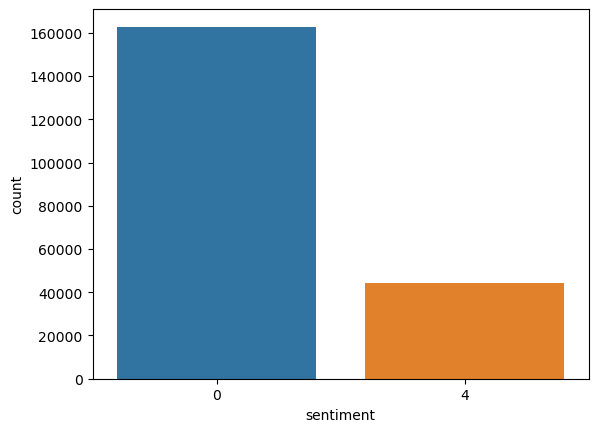

In [105]:
sns.countplot(data = data_new, x = data_new['sentiment'])

### Create X and y

In [106]:
X = data_new['text']
y = data_new['sentiment']

# from sklearn.preprocessing import LabelEncoder
# enc = LabelEncoder()
# y_trans = enc.fit_transform(y)

### Vectorizer

In [107]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(X)

In [108]:
sorted(vectorizer.vocabulary_.keys())

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaa',
 'aaaaaaa',
 'aaaaaaaa',
 'aaaaaaaaa',
 'aaaaaaaaaa',
 'aaaaaaaaaaaa',
 'aaaaaaaaaaaaa',
 'aaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaah',
 'aaaaaaaaaaaaaah',
 'aaaaaaaaaaaaaalllll',
 'aaaaaaaaaaaah',
 'aaaaaaaaaaand',
 'aaaaaaaaaaarggggggggh',
 'aaaaaaaaaah',
 'aaaaaaaaaahhhhh',
 'aaaaaaaaah',
 'aaaaaaaaaw',
 'aaaaaaaafternoon',
 'aaaaaaaah',
 'aaaaaaaahhhhhhhh',
 'aaaaaaaahhhhhhhhh',
 'aaaaaaaall',
 'aaaaaaaargh',
 'aaaaaaackkkkkk',
 'aaaaaaages',
 'aaaaaaah',
 'aaaaaaahh',
 'aaaaaaahhh',
 'aaaaaaahhhhhhh',
 'aaaaaaall',
 'aaaaaaand',
 'aaaaaaargggghh',
 'aaaaaaaw',
 'aaaaaaawwww',
 'aaaaaaghhhhh',
 'aaaaaah',
 'aaaaaahhh',
 'aaaaaahhhh',
 'aaaaaak',
 'aaaaaand',
 'aaaaaarggggggggg',
 'aaaaaargh',
 'aaaaaarrrghhh',
 'aaaaaawwww',
 'aaaaaawwwwwwww',
 'aaaaachhhooo',
 'aaaaages',
 'aaaaagh',
 'aaaaah',
 'aaaaahhh',
 'aaaaahhhh',
 'aaaaalll',
 'aaaaallll',
 'aaaaand',
 'aaaaannnnd',
 'aaaaanttz',
 'aaaaaoouoouoouu',
 'aaaaarg',
 'aaaaargh',
 'aaaaarrgh

In [109]:
sorted(vectorizer.vocabulary_.items(), key = lambda x: x[1], reverse = True)

[('ðµñ', 93142),
 ('ðµð', 93141),
 ('ðµ', 93140),
 ('ãºlitmo', 93139),
 ('ãµuest', 93138),
 ('ãªtre', 93137),
 ('âª', 93136),
 ('ªã', 93135),
 ('zzzzzzzzzzzzzzzzzzzzz', 93134),
 ('zzzzzzzzzzzzzzzzzzz', 93133),
 ('zzzzzzzzzzzzzzzzzz', 93132),
 ('zzzzzzzzzzzzzzzz', 93131),
 ('zzzzzzzzzzzzzzz', 93130),
 ('zzzzzzzzzzzzzz', 93129),
 ('zzzzzzzzzzzzz', 93128),
 ('zzzzzzzzzzzs', 93127),
 ('zzzzzzzzzzz', 93126),
 ('zzzzzzzzzz', 93125),
 ('zzzzzzzzz', 93124),
 ('zzzzzzzzlullaby', 93123),
 ('zzzzzzzz', 93122),
 ('zzzzzzz', 93121),
 ('zzzzzz', 93120),
 ('zzzzz', 93119),
 ('zzzzs', 93118),
 ('zzzz', 93117),
 ('zzz', 93116),
 ('zzy', 93115),
 ('zzs', 93114),
 ('zzr', 93113),
 ('zzomg', 93112),
 ('zzombie', 93111),
 ('zz', 93110),
 ('zyrtec', 93109),
 ('zynga', 93108),
 ('zygotic', 93107),
 ('zydrate', 93106),
 ('zyder', 93105),
 ('zyb', 93104),
 ('zyanya', 93103),
 ('zwolle', 93102),
 ('zwischendurch', 93101),
 ('zweite', 93100),
 ('zwart', 93099),
 ('zw', 93098),
 ('zvysit', 93097),
 ('zuzu', 93096

### Split data train and test

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, y, test_size=0.3, random_state=52)

### Resample for imbalanced target

In [111]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy = 'minority')
X_train_resamp, y_train_resamp = smote.fit_resample(X_train, y_train)

In [113]:
feat_names = vectorizer.get_feature_names_out()
X_train_df  = pd.DataFrame(X_train_resamp.toarray(), columns = feat_names)

In [ ]:
sns.countplot(data = data_new, x = X_train_df)

## Modeling

### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression()
logreg_model.fit(X_train_resamp, y_train_resamp)
y_pred = logreg_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

/Users/nechamaborisute/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.89      0.78      0.83     48701
           4       0.45      0.66      0.54     13503

    accuracy                           0.75     62204
   macro avg       0.67      0.72      0.68     62204
weighted avg       0.80      0.75      0.77     62204



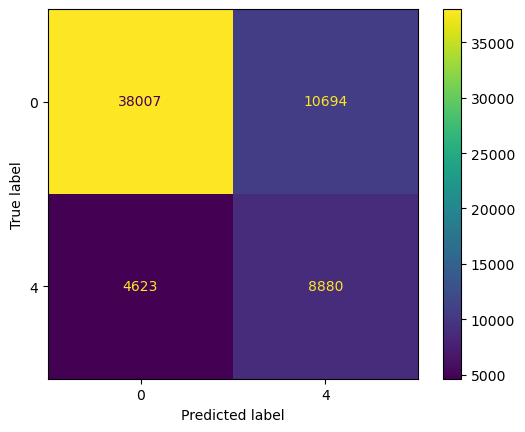

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(logreg_model, X_test, y_test)

### Decision Trees

In [41]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_resamp, y_train_resamp)
y_pred_dt = dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82     48701
         2.0       0.00      0.00      0.00         0
         4.0       0.36      0.34      0.35     13503

    accuracy                           0.72     62204
   macro avg       0.39      0.39      0.39     62204
weighted avg       0.72      0.72      0.72     62204



/Users/nechamaborisute/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nechamaborisute/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nechamaborisute/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

### ComplementNB

In [42]:
from sklearn.naive_bayes import ComplementNB

compnb = ComplementNB()
compnb.fit(X_train_resamp, y_train_resamp)
y_pred_nb = compnb.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81     48701
           4       0.41      0.65      0.51     13503

    accuracy                           0.72     62204
   macro avg       0.65      0.70      0.66     62204
weighted avg       0.78      0.72      0.74     62204



### MultinomialNB

In [43]:
from sklearn.naive_bayes import MultinomialNB

multinb = MultinomialNB()
multinb.fit(X_train_resamp, y_train_resamp)
y_pred_multi_nb = multinb.predict(X_test)
print(classification_report(y_test, y_pred_multi_nb))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81     48701
           4       0.41      0.65      0.51     13503

    accuracy                           0.72     62204
   macro avg       0.65      0.70      0.66     62204
weighted avg       0.78      0.72      0.74     62204



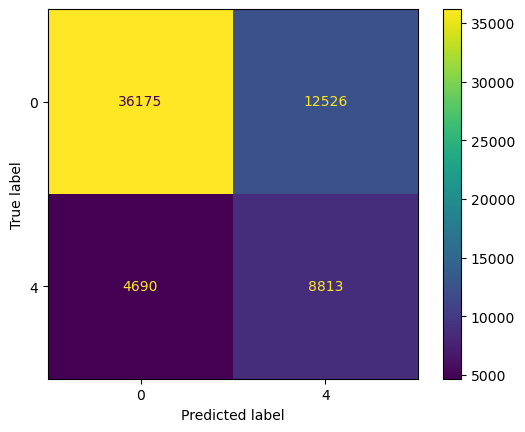

In [44]:
ConfusionMatrixDisplay.from_estimator(multinb, X_test, y_test)